# Dixon Decomposition Artifact Troubleshooting

## Import Libraries 

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
import concurrent.futures
import time
import tqdm
import cv2
import os
import scipy.io

## Load Data

In [97]:
# load the .mat file (MEPOXE0039 Post)
# gradient delays of -7 
mat_data = scipy.io.loadmat('/Users/mia/Desktop/test/MepoXe39Post.mat')

# access variables from the loaded data
mask_vent = mat_data['mask_vent']
mask_vent = (mask_vent != 0) # convert non-zero elements to True, zero elements to False
gas_highSNR = mat_data['image_gas_highsnr']
dissolved = mat_data['image_dissolved']

In [98]:
# OLD DATA (bad gradient delays!!)
#gas_highSNR=np.load('data/gas_afia.npy')
#dissolved=np.load('data/dp_afia.npy')
#mask_vent=np.load('data/mask_afia.npy')

## Define Custom Functions

In [157]:
def gridMRIdata(trajlist,MRIdata,castlist):
    ''' This is pretty much just the griddata function but setup to 
        use the concurrent futures module to speed up interpolation 
        of large, complex datasets

    inputs: trajlist (Nx3 array of kx,ky,kz coords corresponding to MRIdata)
            MRIdata (length N vector of complex data)
            castlist (Nx3 array of kx, ky, kz to interpolate too)
    outputs: interpolated_data (Nx4 array of kx,ky,kz,interpolated complex data)
    '''
    Nblocks = 32
    interpolated_real = []
    chunk_size = int(castlist.shape[0]/Nblocks)
    starttime = time.time()
    with concurrent.futures.ThreadPoolExecutor() as executor:
        realdata = [executor.submit(griddata, trajlist, MRIdata, castlist[np.add(range(0,chunk_size),k*chunk_size),:]) for k in range(0,Nblocks)]
        concurrent.futures.wait(realdata)
        for f1 in realdata:
            interpolated_real.append(f1.result())
    realdata = np.vstack(interpolated_real).flatten()
    data = [realdata[i] for i in range(len(realdata))]
    interpolated_data = np.column_stack((castlist[range(len(data)),:],data))
    completeTime = int(np.round((time.time() - starttime)))
    print(f'\n ## -- Time to interpolate {interpolated_data.shape[0]} points: {round(completeTime/60,2)} min. -- ##')
    return interpolated_data

def makeSlide(image_array, cmap='bwr'):
    # Check if the input is a 3D array
    if len(image_array.shape) != 3:
        raise ValueError("Input should be a 3D array.")

    # Determine the colorbar range
    min_val = np.nanmin(image_array)
    max_val = np.nanmax(image_array)
    if np.isnan(min_val) or np.isnan(max_val):
        min_val = -1  # Set a default minimum value if NaN
        max_val = 1   # Set a default maximum value if NaN

    num_slices = image_array.shape[2]
    num_rows = int(np.ceil(np.sqrt(num_slices)))
    num_cols = int(np.ceil(num_slices / num_rows))
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        if i < num_slices:
            im = ax.imshow(image_array[:, :, i], cmap=cmap, vmin=min_val, vmax=max_val)
            ax.axis('off')
            ax.set_title(f"Slice {i+1}")

    # Add a single color bar for the entire montage
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.05, pad=0.05, ticks=[min_val, 0, max_val])  # Specify colorbar ticks manually
    cbar.ax.set_yticklabels([f'{min_val:.2f}', '0', f'{max_val:.2f}'])  # Set tick labels
    plt.show()


def dataList_to_ImageArray(traj, data, N=128):
    '''turns Mx3 kSpace coords and M data into an NxNxN image'''
    F = np.zeros((N, N, N),dtype=np.complex_)
    for k in range(len(data)):
        F[int(round(traj[k, 0])), int(round(traj[k, 1])), int(round(traj[k, 2]))] = data[k]
    F[~np.isfinite(F)] = 0
    return F

"""## **Dixon decompoistion for NO GUI**
The following code was copied from NO GUI code. GO to utils/img_utils/dixon_decomposition function
"""
def correct_b0(
    image: np.ndarray, mask: np.ndarray, max_iterations: int = 100
) -> np.ndarray:
    """Correct B0 inhomogeneity.

    Args:
        image (np.ndarray): image to correct.
        mask (np.ndarray): mask of the image. must be same shape as image.
        max_iterations (int, optional): maximum number of iterations. Defaults to 20.
    Returns:
        Corrected phase of the corrected image.
    """
    index = 0
    meanphase = 1

    while abs(meanphase) > 1e-7:
        index = index + 1
        diffphase = np.angle(image)
        meanphase = np.mean(diffphase[mask])  # type: ignore
        image = np.multiply(image, np.exp(-1j * meanphase))
        print(f'meanphase = {meanphase*180/np.pi}')
        if index > max_iterations:
            break
    return np.angle(image)  # type: ignore

# display the selected slices for each array
def display_slices(arr, row):
    ss=60
    for i in range(7):
        plt.subplot(3, 7, row * 7 + i + 1)
        plt.imshow(abs(arr[:, :, ss]), cmap='gray')
        ss=ss+1
        plt.axis('off')
        plt.subplots_adjust(wspace=0)

## Exploring Code

In [100]:
rbc_m_ratio=0.45152 # generated from flip cal 

desired_angle = np.arctan2(rbc_m_ratio, 1.0)
current_angle = np.angle(np.sum(dissolved[mask_vent > 0]))
delta_angle = desired_angle - current_angle
print('\033[31mdesired_angle\033[37m',desired_angle*180/np.pi)
print('\033[31mcurrent_angle\033[37m',current_angle*180/np.pi)
print('\033[31mdelta\033[37m',delta_angle*180/np.pi)

desired_angle 24.300127878335054
current_angle 21.260109219184777
delta 3.040018659150279


## Correcting B0 (cause of artifact)

In [101]:
diffphase = correct_b0(gas_highSNR, mask_vent)

meanphase = -55.27980682422802
meanphase = -1.529746146087323e-14


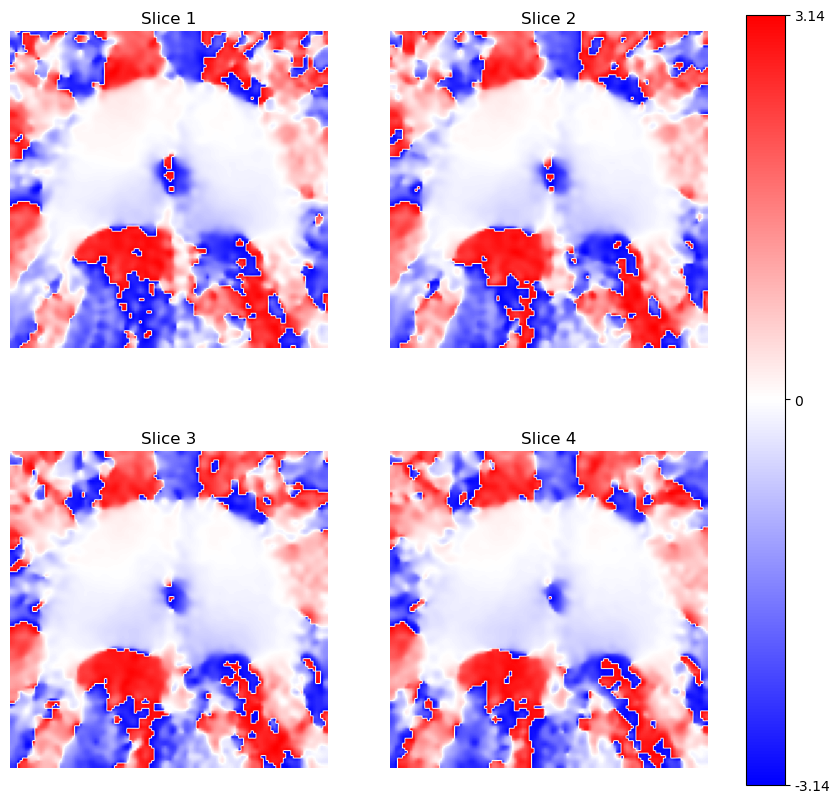

In [102]:
makeSlide(diffphase[:, :, 66:70])

In [103]:
# multiply phase difference array by the mask
# values outside the mask will be set to zero, retaining only the phase inside the mask
phase_inside_mask = diffphase * mask_vent

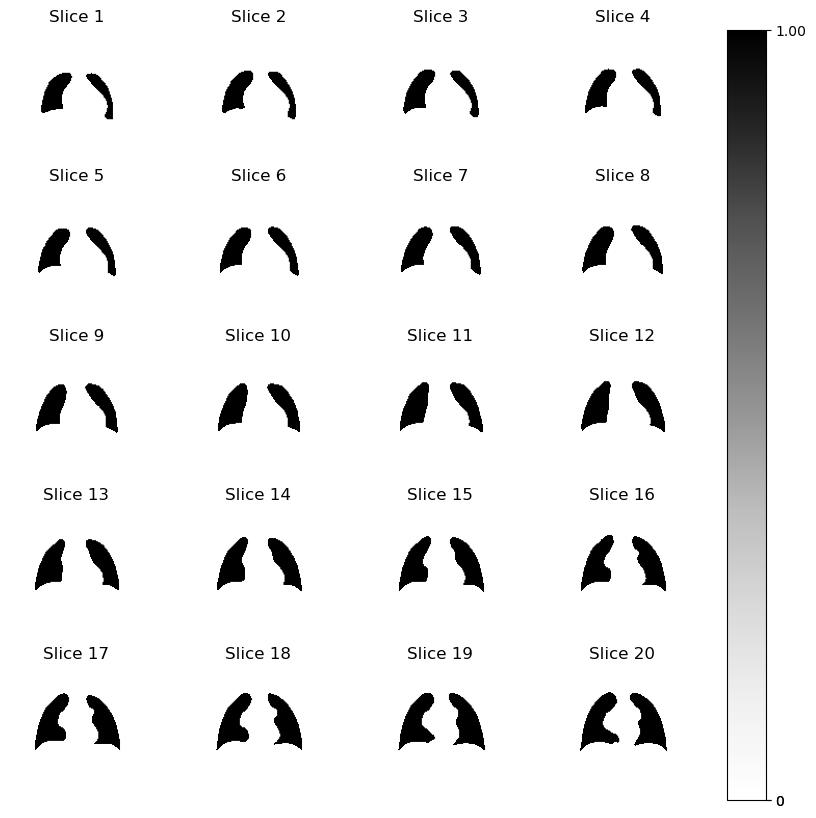

In [104]:
makeSlide(mask_vent[:, :, 50:70], cmap='Greys')

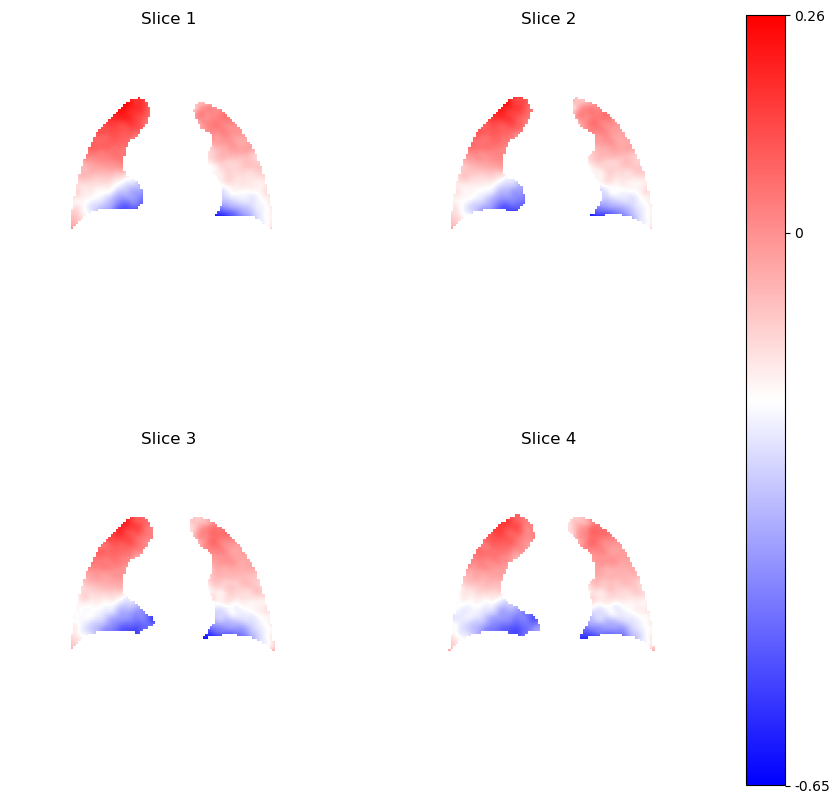

In [13]:
# convert zero values to NaN to avoid matplotlib interpolation in display
phase_inside_mask_nan = np.where(phase_inside_mask == 0, np.nan, phase_inside_mask)

makeSlide(phase_inside_mask_nan[:, :, 66:70])

## Testing Phase Map Smoothing Methods

### 1. Simple Gaussian Filter

In [14]:
from scipy.ndimage import gaussian_filter

def smooth_mask_borders(image, sigma):
    # Apply Gaussian smoothing to the image
    smoothed_image = gaussian_filter(image.astype(float), sigma=sigma)
    return smoothed_image

smoothed_image = smooth_mask_borders(phase_inside_mask, sigma=2)

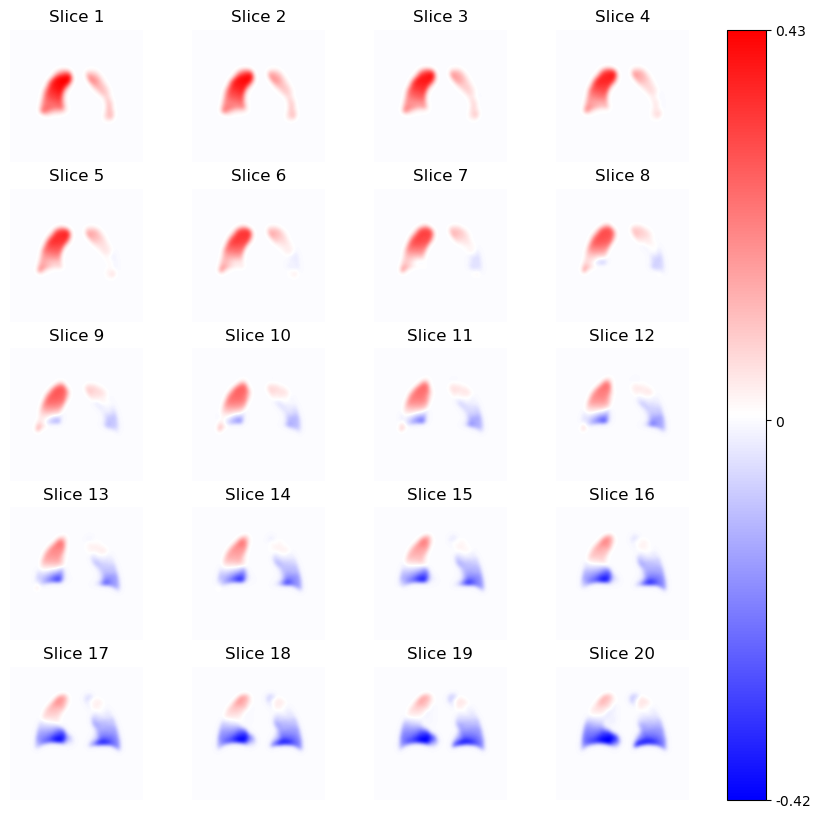

In [15]:
makeSlide(smoothed_image[:, :, 50:70])

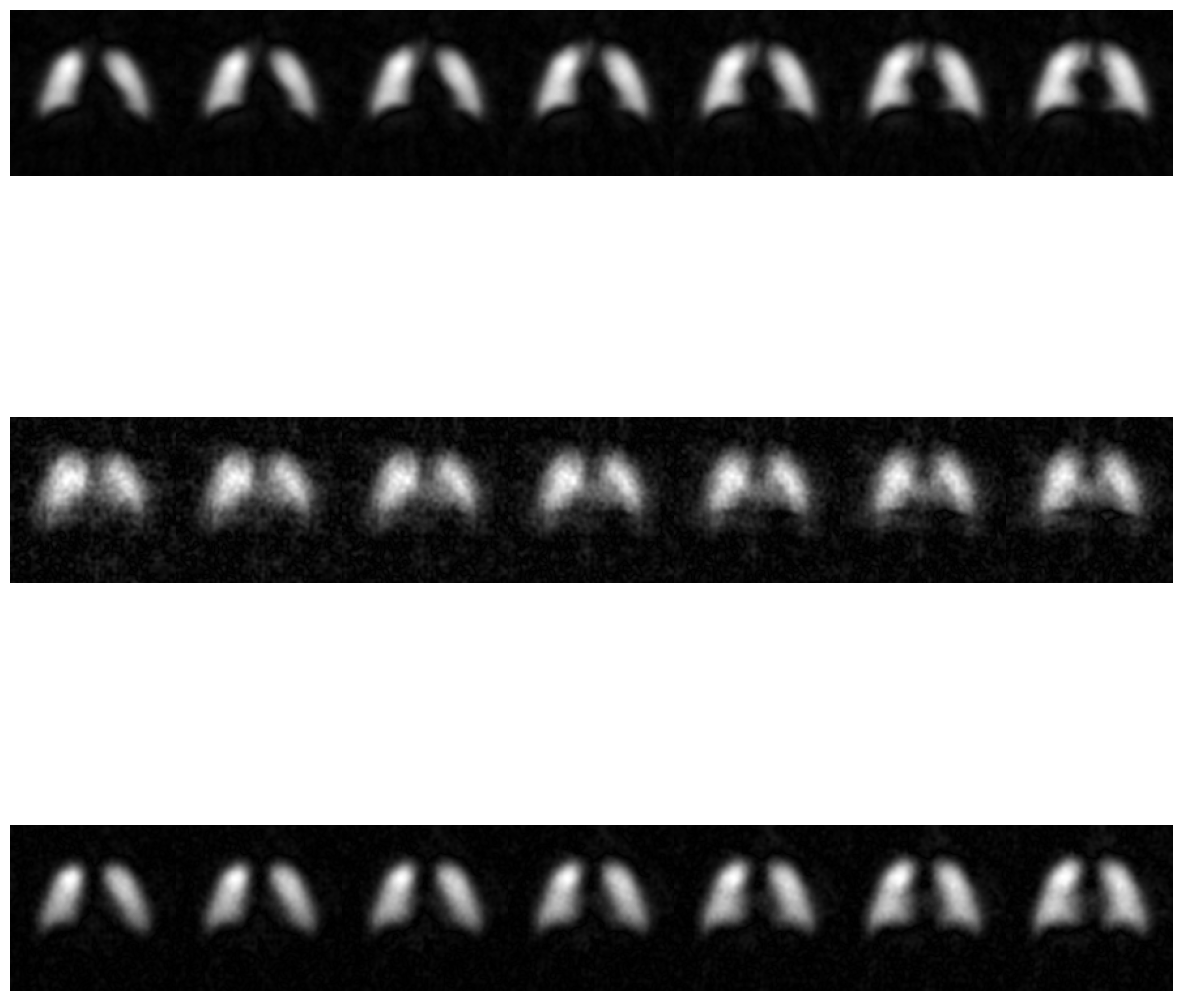

In [18]:
image_dixon = np.multiply(dissolved, np.exp(1j * (delta_angle)))
image_dixon = np.multiply(image_dixon, np.exp(1j * (-smoothed_image)))
image_rbc = (
        np.imag(image_dixon)
        if np.mean(np.imag(image_dixon)) > 0
        else -1 * np.imag(image_dixon)  # type: ignore
    )
image_membrane = (
        np.real(image_dixon)
        if np.mean(np.real(image_dixon)) > 0
        else -1 * np.real(image_dixon)  # type: ignore
    )
        
plt.figure(figsize=(15,15))
display_slices(gas_highSNR, row=0);display_slices(image_rbc, row=1);display_slices(image_membrane, row=2)
plt.show()

THOUGHTS: removes ring around the heart but adds other harsh lines black lines to the RBC image, most likely due to sharp phase transitions (from positive phase to negative phase) in the modified phase map. Not good. 

### 2. Simple Median Filter

In [19]:
from scipy.ndimage import median_filter

def smooth_mask_borders_median(image, size):
    # Apply median filtering to the image
    smoothed_image = median_filter(image.astype(float), size=size)
    return smoothed_image

smoothed_image_median = smooth_mask_borders_median(phase_inside_mask, size=5)

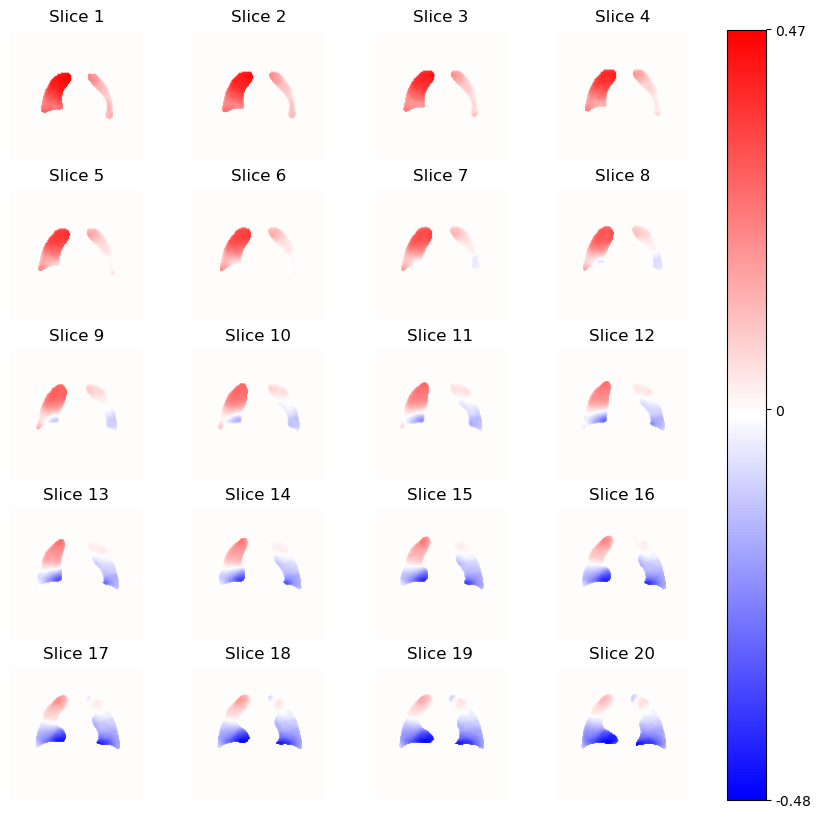

In [20]:
makeSlide(smoothed_image_median[:, :, 50:70])

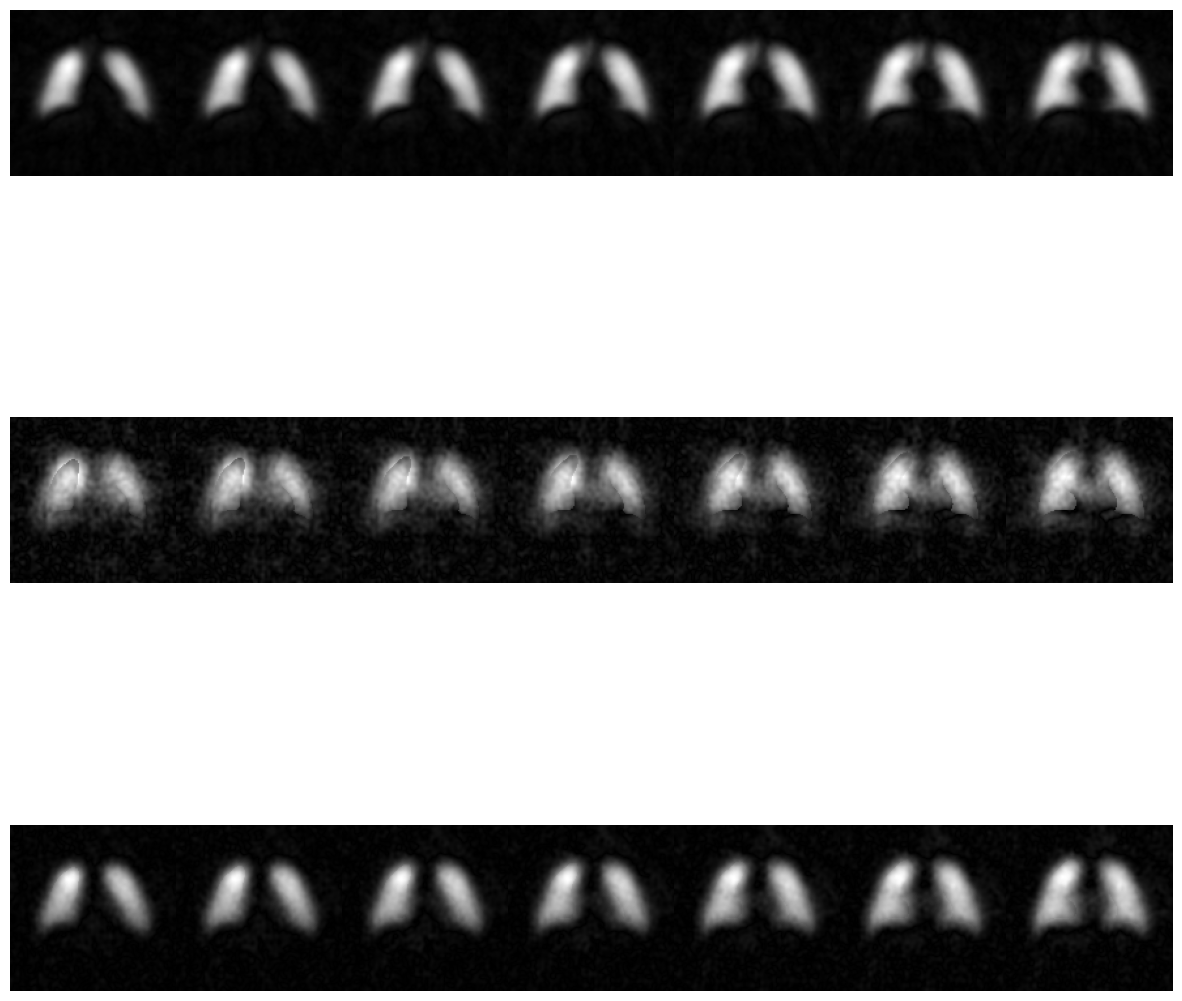

In [21]:
image_dixon = np.multiply(dissolved, np.exp(1j * (delta_angle)))
image_dixon = np.multiply(image_dixon, np.exp(1j * (-smoothed_image_median)))
image_rbc = (
        np.imag(image_dixon)
        if np.mean(np.imag(image_dixon)) > 0
        else -1 * np.imag(image_dixon)  # type: ignore
    )
image_membrane = (
        np.real(image_dixon)
        if np.mean(np.real(image_dixon)) > 0
        else -1 * np.real(image_dixon)  # type: ignore
    )
        
plt.figure(figsize=(15,15))
display_slices(gas_highSNR, row=0);display_slices(image_rbc, row=1);display_slices(image_membrane, row=2)
plt.show()

THOUGHTS: very, very bad RBC images. Not a good technique for what we are trying to do here...

### 3. Simple Box Filter

In [22]:
from scipy.ndimage import uniform_filter

def smooth_mask_borders_box(image, size):
    # Apply box filtering to the image
    smoothed_image = uniform_filter(image.astype(float), size=size)
    return smoothed_image

# Example usage
smoothed_image_box = smooth_mask_borders_box(phase_inside_mask, size=5)

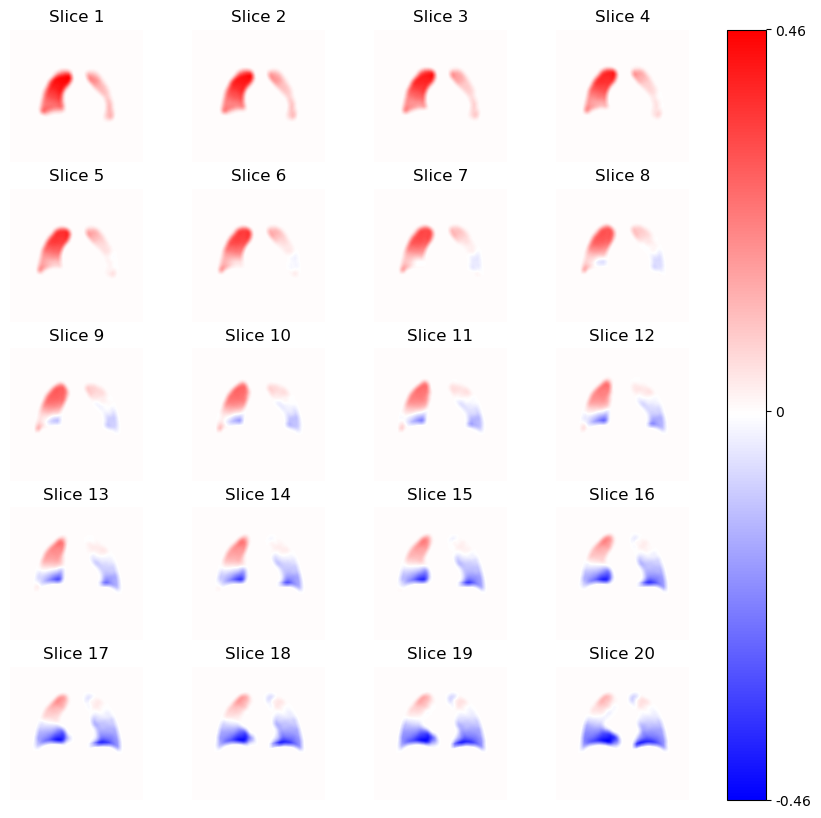

In [23]:
makeSlide(smoothed_image_box[:, :, 50:70])

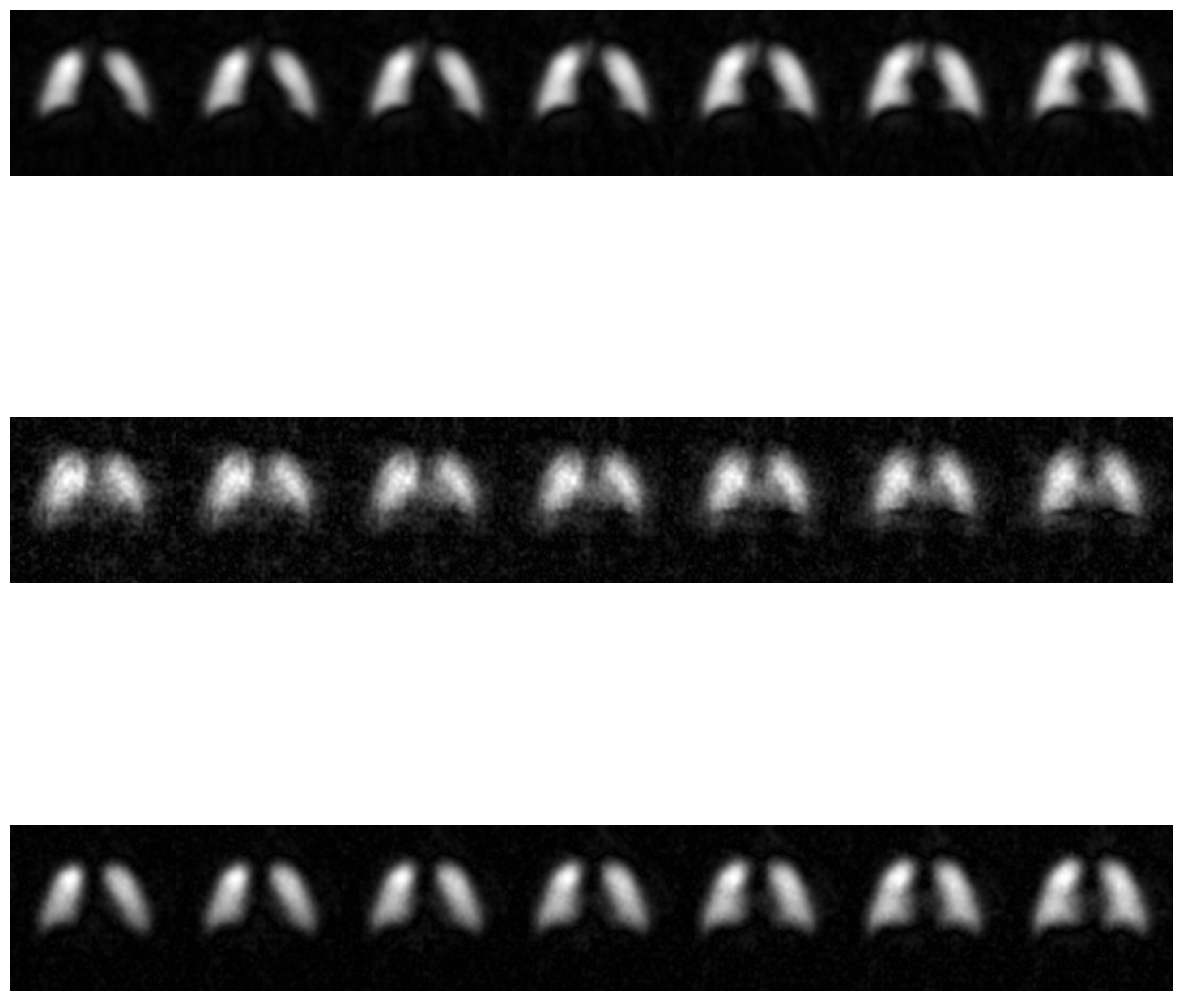

In [24]:
image_dixon = np.multiply(dissolved, np.exp(1j * (delta_angle)))
image_dixon = np.multiply(image_dixon, np.exp(1j * (-smoothed_image_box)))
image_rbc = (
        np.imag(image_dixon)
        if np.mean(np.imag(image_dixon)) > 0
        else -1 * np.imag(image_dixon)  # type: ignore
    )
image_membrane = (
        np.real(image_dixon)
        if np.mean(np.real(image_dixon)) > 0
        else -1 * np.real(image_dixon)  # type: ignore
    )
        
plt.figure(figsize=(15,15))
display_slices(gas_highSNR, row=0);display_slices(image_rbc, row=1);display_slices(image_membrane, row=2)
plt.show()

THOUGHTS: better than median filter, but about the same level of bad or maybe even worse compared to the guassian blur. We still see harsh black lines toward the bottom of the lungs in the RBC images. Here we can also see a slight outline (border) of the lung in the RBC image too...

### 4. Dilate Mask, Define Transition Region, Distance Transform Map, Multiplying by Diffphase

In [25]:
from scipy.ndimage import binary_dilation, distance_transform_edt

# define transition region (region between original mask and dilated mask borders)
border_mask = binary_dilation(mask_vent, iterations=6) & ~mask_vent
transition_region = border_mask.copy()
transition_region = binary_dilation(transition_region, iterations=6)

# calculate the distance between the original mask border to the dilated mask border 
# values close to the orignal border should be close to zero, values closer to the dilated border should grow larger 
distance_map = distance_transform_edt(1 - mask_vent)
distance_map /= 6
distance_map = np.clip(distance_map, 0, 1)
distance_map = distance_map * border_mask
distance_map = 1 - distance_map

# normalize between 0 and 1 
min_val = np.min(distance_map)
max_val = np.max(distance_map)
normalized_distance_map = (distance_map - min_val) / (max_val - min_val)

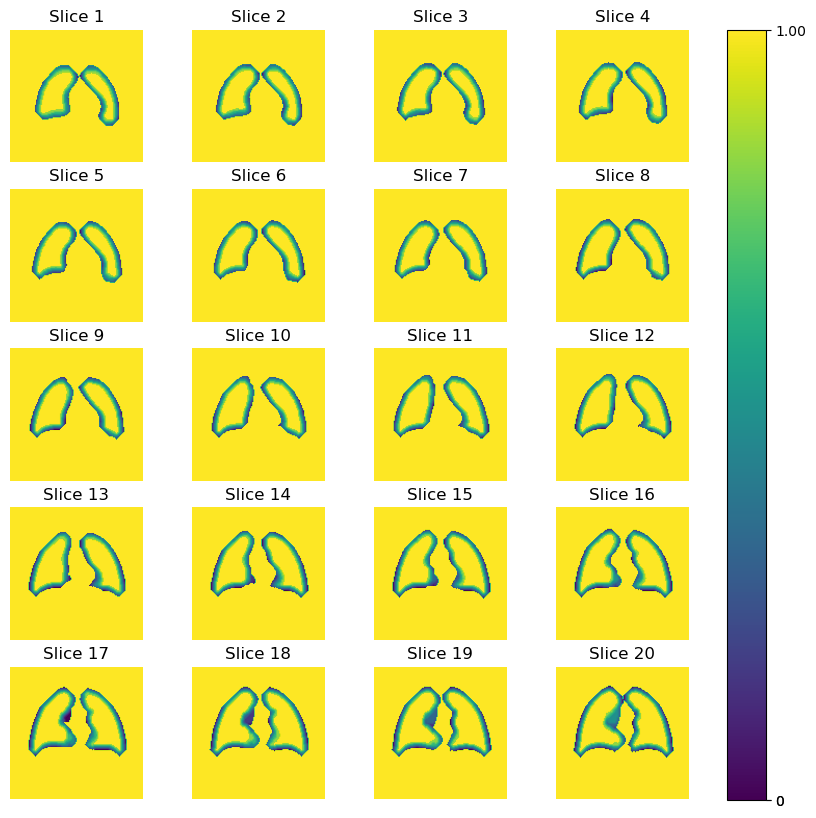

In [26]:
makeSlide(normalized_distance_map[:, :, 50:70], cmap='viridis')

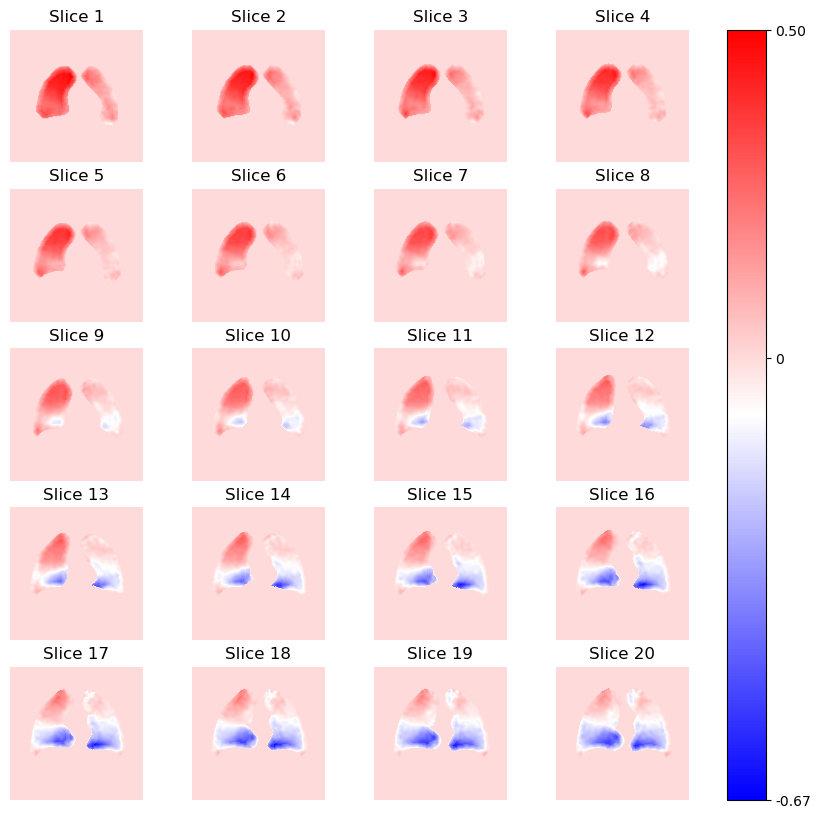

In [27]:
test = normalized_distance_map * diffphase
dilated_mask = binary_dilation(mask_vent, iterations=5)
test = test * dilated_mask
makeSlide(test[:, :, 50:70])

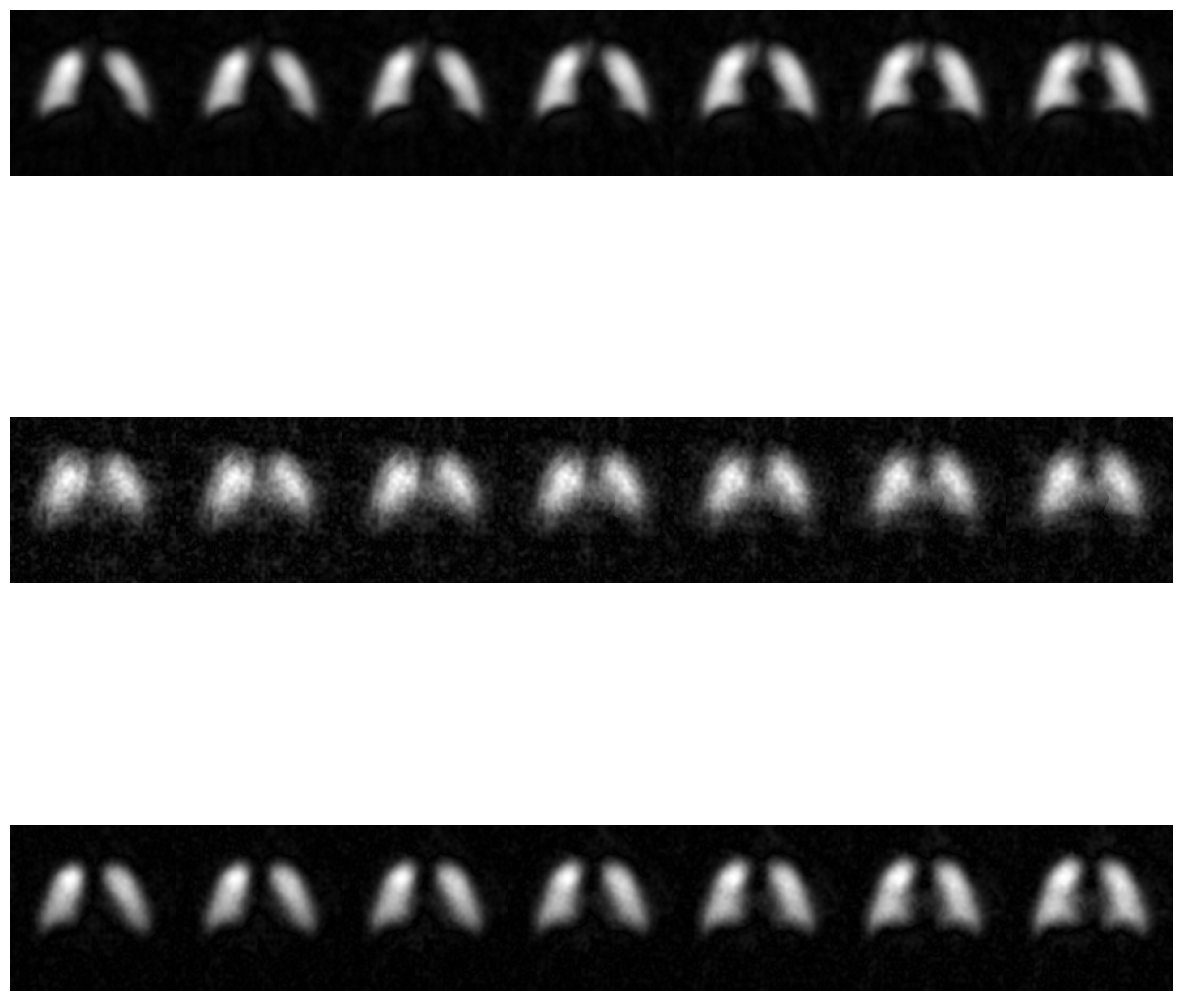

In [28]:
image_dixon = np.multiply(dissolved, np.exp(1j * (delta_angle)))
image_dixon = np.multiply(image_dixon, np.exp(1j * (-test)))
image_rbc = (
        np.imag(image_dixon)
        if np.mean(np.imag(image_dixon)) > 0
        else -1 * np.imag(image_dixon)  # type: ignore
    )
image_membrane = (
        np.real(image_dixon)
        if np.mean(np.real(image_dixon)) > 0
        else -1 * np.real(image_dixon)  # type: ignore
    )
        
plt.figure(figsize=(15,15))
display_slices(gas_highSNR, row=0);display_slices(image_rbc, row=1);display_slices(image_membrane, row=2)
plt.show()

THOUGHTS: not terrible, still not a fan of the border around the lung in the some of the RBC images, however. 

### 5. Dilate & Guassian Blurring

In [137]:
from scipy.ndimage import binary_dilation

# Assuming your 3D numpy array is named 'image_array'
# and has dimensions (depth, height, width)

# Define the structuring element for dilation
kernel = np.ones((5, 5, 5))

# Perform dilation
dilated_mask = binary_dilation(mask_vent, kernel)

In [138]:
# multiply phase difference array by the mask
# values outside the mask will be set to zero, retaining only the phase inside the mask
phase_inside_mask2 = diffphase * dilated_mask

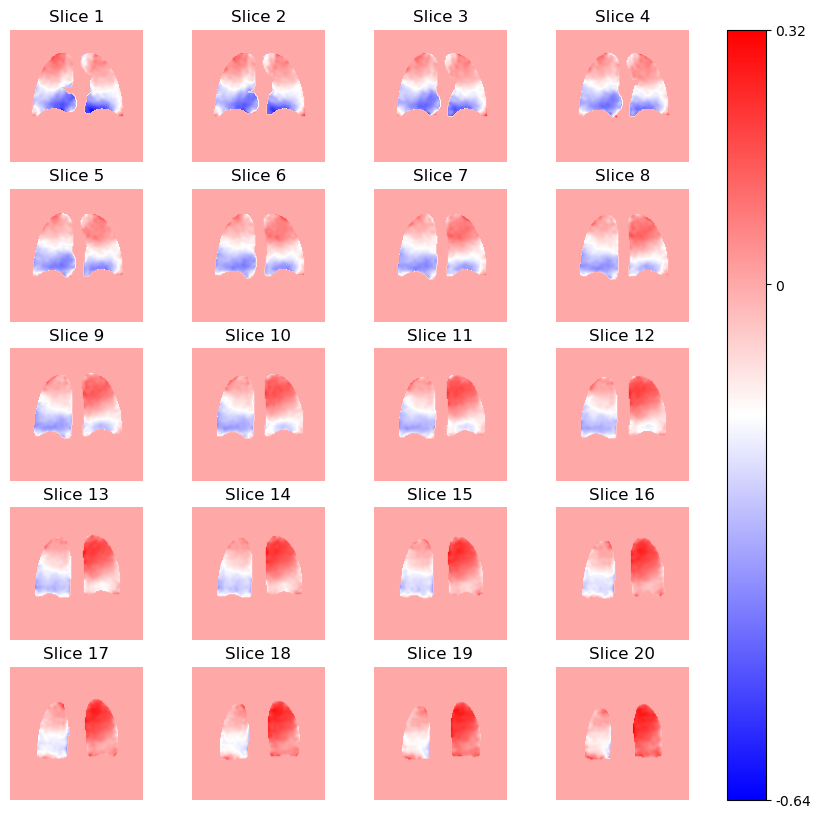

In [139]:
makeSlide(phase_inside_mask2[:,:,70:90])

In [152]:
from scipy.ndimage import gaussian_filter

def smooth_mask_borders(image, sigma):
    # Apply Gaussian smoothing to the image
    smoothed_image = gaussian_filter(image.astype(float), sigma=sigma)
    return smoothed_image

smoothed_image = smooth_mask_borders(phase_inside_mask2, sigma=2)

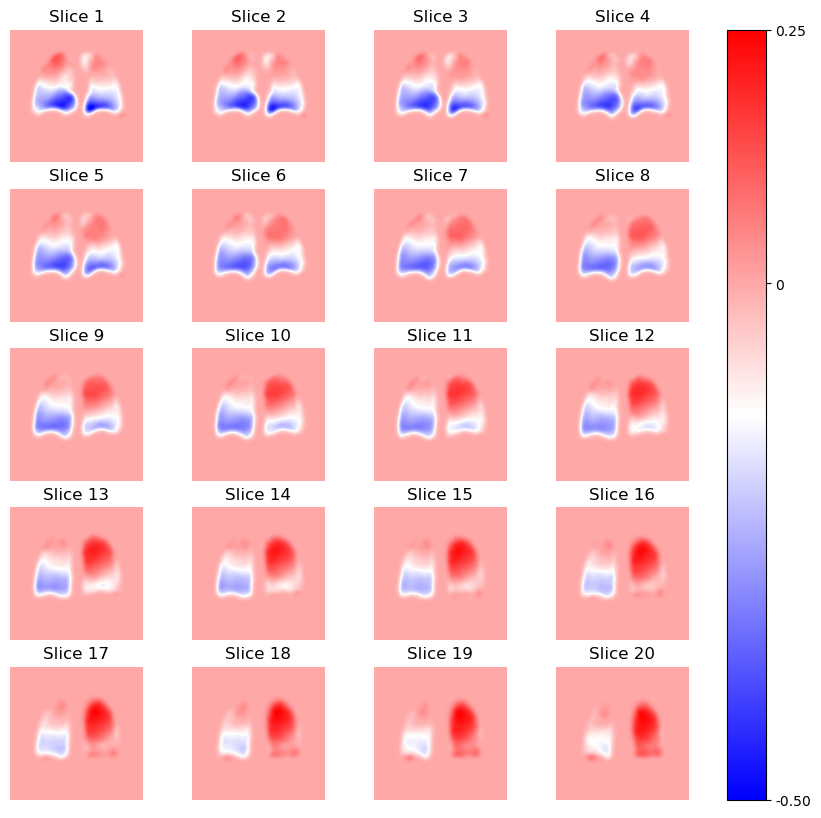

In [153]:
makeSlide(smoothed_image[:,:,70:90])

Text(0.5, 1.0, 'Boxplots')

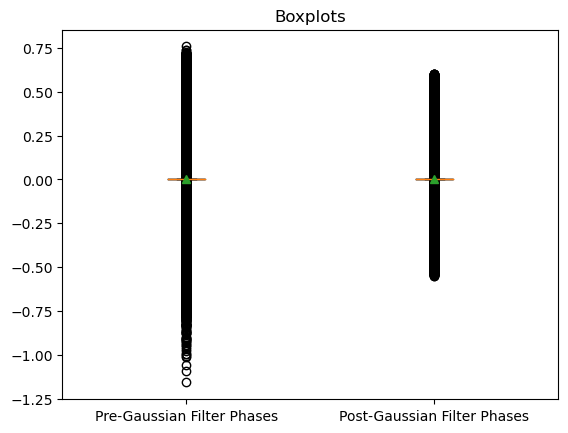

In [170]:
plt.boxplot([phase_inside_mask2.reshape(phase_inside_mask2.shape[1]**3),
             smoothed_image.reshape(smoothed_image.shape[1]**3)],
             showfliers=True, showmeans=True,
           labels=["Pre-Gaussian Filter Phases", 'Post-Gaussian Filter Phases'])
plt.title('Boxplots')

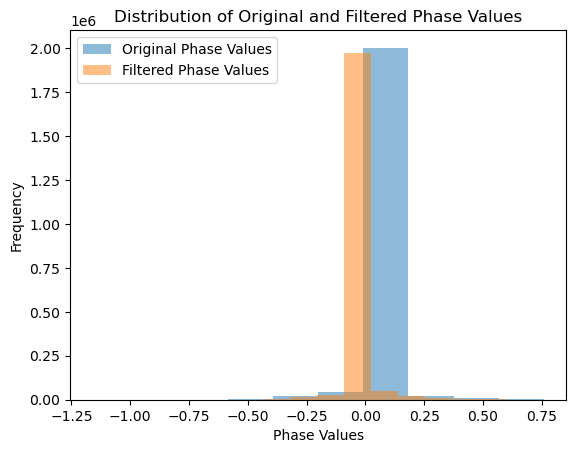

Original Phase Values:
Mean: 0.001217042724770053
Median: 0.0

Filtered Phase Values:
Mean: 0.001217042724770053
Median: 0.0

Mean Squared Error (MSE): 0.0003757430114035954
Structural Similarity Index (SSIM): 0.9747181290532759


In [180]:
from skimage.metrics import mean_squared_error, structural_similarity as ssim

# Plot histograms
plt.hist(phase_inside_mask2.reshape(phase_inside_mask2.shape[1]**3), bins=10, alpha=0.5, label='Original Phase Values')
plt.hist(smoothed_image.reshape(smoothed_image.shape[1]**3), bins=10, alpha=0.5, label='Filtered Phase Values')

# Add labels and title
plt.xlabel('Phase Values')
plt.ylabel('Frequency')
plt.title('Distribution of Original and Filtered Phase Values')

# Add legend
plt.legend()

# Show plot
plt.show()

# Calculate means and medians
mean_original = np.mean(phase_inside_mask2)
median_original = np.median(phase_inside_mask2)
mean_filtered = np.mean(smoothed_image)
median_filtered = np.median(smoothed_image)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(phase_inside_mask2, smoothed_image)

# Calculate Structural Similarity Index (SSIM)
ssim_index = ssim(phase_inside_mask2, smoothed_image)

# Print statistics
print("Original Phase Values:")
print("Mean:", mean_original)
print("Median:", median_original)
print("\nFiltered Phase Values:")
print("Mean:", mean_filtered)
print("Median:", median_filtered)
print("\nMean Squared Error (MSE):", mse)
print("Structural Similarity Index (SSIM):", ssim_index)


In [182]:
import numpy as np
from scipy.stats import ks_2samp

# Assuming 'original_image' and 'filtered_image' are your 3D image arrays

# Flatten the images into 1D arrays
original_phase_values = phase_inside_mask2.flatten()
filtered_phase_values = smoothed_image.flatten()

# Perform the two-sample KS test
ks_statistic, p_value = ks_2samp(original_phase_values, filtered_phase_values)

# Print the test result
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The distributions are significantly different.")
else:
    print("Fail to reject the null hypothesis: The distributions are not significantly different.")


KS Statistic: 0.09086847305297852
P-value: 0.0
Reject the null hypothesis: The distributions are significantly different.


In [183]:
import numpy as np

# Assuming 'original_image' and 'filtered_image' are your 3D image arrays

# Flatten the images into 1D arrays
original_phase_values = phase_inside_mask2.flatten()
filtered_phase_values = smoothed_image.flatten()

# Compute the squared difference between corresponding pixel values
squared_diff = (original_phase_values - filtered_phase_values) ** 2

# Calculate the mean of the squared differences
mean_squared_diff = np.mean(squared_diff)

# Take the square root to obtain the RMSE
rmse = np.sqrt(mean_squared_diff)

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.019384091709533244


In [185]:
from scipy.stats import wilcoxon

# Assuming 'original_phase_values' and 'filtered_phase_values' are your data arrays

# Flatten the images into 1D arrays
original_phase_values = phase_inside_mask2.flatten()
filtered_phase_values = smoothed_image.flatten()

# Perform the Wilcoxon signed-rank test
statistic, p_value = wilcoxon(original_phase_values, filtered_phase_values)

# Print the test result
print("Wilcoxon Signed-Rank Test:")
print("Test Statistic:", statistic)
print("P-value:", p_value)

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The distributions are significantly different.")
else:
    print("Fail to reject the null hypothesis: The distributions are not significantly different.")


Wilcoxon Signed-Rank Test:
Test Statistic: 44175848308.0
P-value: 0.0
Reject the null hypothesis: The distributions are significantly different.


In [168]:
smoothed_image.shape

(128, 128, 128)

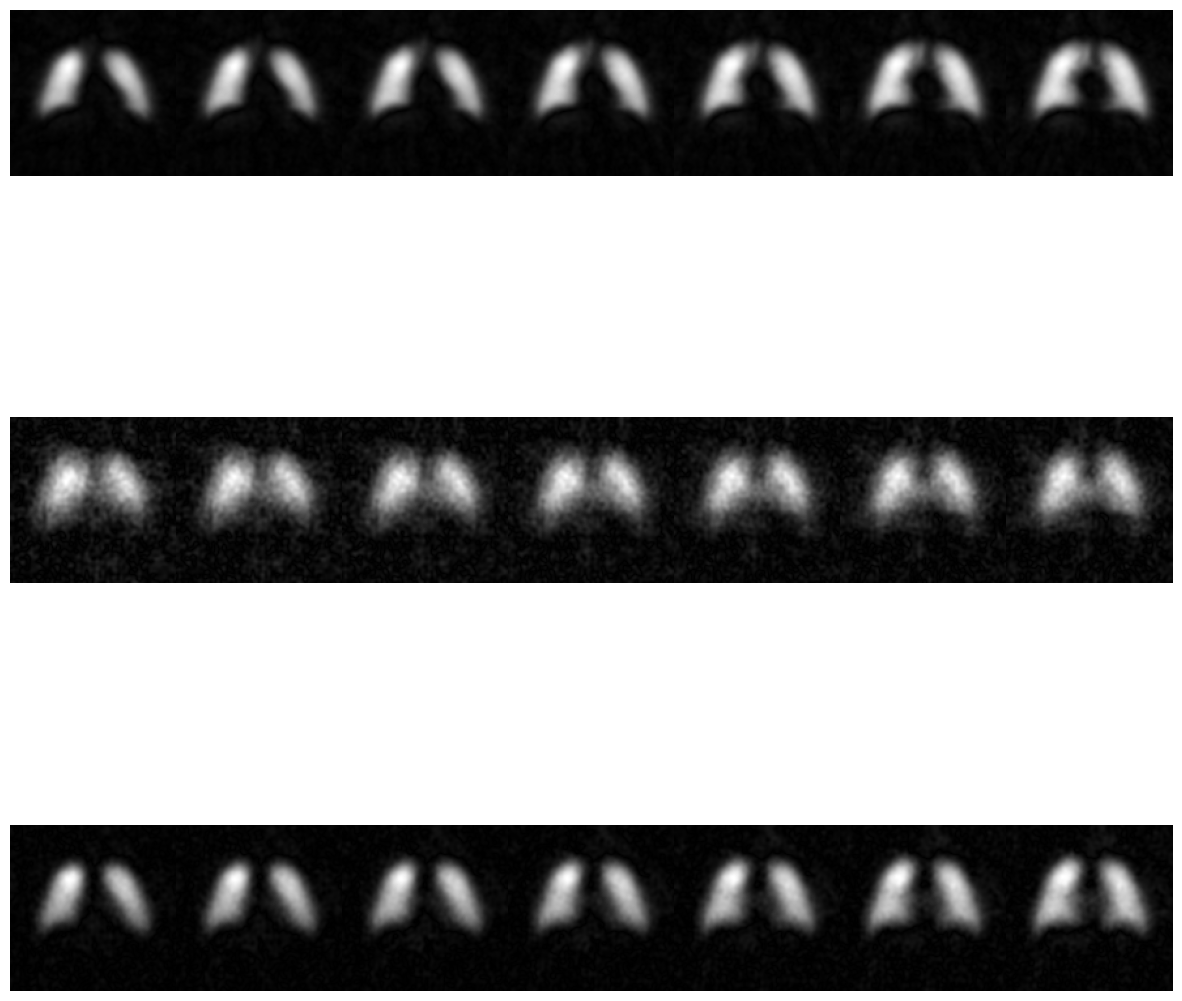

In [163]:
image_dixon = np.multiply(dissolved, np.exp(1j * (delta_angle)))
image_dixon = np.multiply(image_dixon, np.exp(1j * (-smoothed_image)))
image_rbc = (
        np.imag(image_dixon)
        if np.mean(np.imag(image_dixon)) > 0
        else -1 * np.imag(image_dixon)  # type: ignore
    )
image_membrane = (
        np.real(image_dixon)
        if np.mean(np.real(image_dixon)) > 0
        else -1 * np.real(image_dixon)  # type: ignore
    )
        
plt.figure(figsize=(15,15))
display_slices(gas_highSNR, row=0);display_slices(image_rbc, row=1);display_slices(image_membrane, row=2)
plt.show()

### Attempting to work with just the border...

In [85]:

def extract_border_mask(phase_inside_mask):
    border_mask = np.zeros_like(phase_inside_mask, dtype=bool)
    
    # Iterate over each voxel in the mask
    for i in range(phase_inside_mask.shape[0]):
        for j in range(phase_inside_mask.shape[1]):
            for k in range(phase_inside_mask.shape[2]):
                # Check if the current voxel is on the border
                if phase_inside_mask[i, j, k]:
                    # Check if any neighbor lies outside the mask
                    for di in range(-1, 2):
                        for dj in range(-1, 2):
                            for dk in range(-1, 2):
                                if (di != 0 or dj != 0 or dk != 0) and \
                                   (i + di < 0 or i + di >= phase_inside_mask.shape[0] or \
                                    j + dj < 0 or j + dj >= phase_inside_mask.shape[1] or \
                                    k + dk < 0 or k + dk >= phase_inside_mask.shape[2] or \
                                    not phase_inside_mask[i + di, j + dj, k + dk]):
                                    border_mask[i, j, k] = True
                                    break
    
    return border_mask

def mask_non_border_values(phase_inside_mask, border_mask):
    masked_phase = np.zeros_like(phase_inside_mask)
    masked_phase[border_mask] = phase_inside_mask[border_mask]
    return masked_phase

# Usage
border_mask = extract_border_mask(phase_inside_mask)
masked_phase = mask_non_border_values(phase_inside_mask, border_mask)


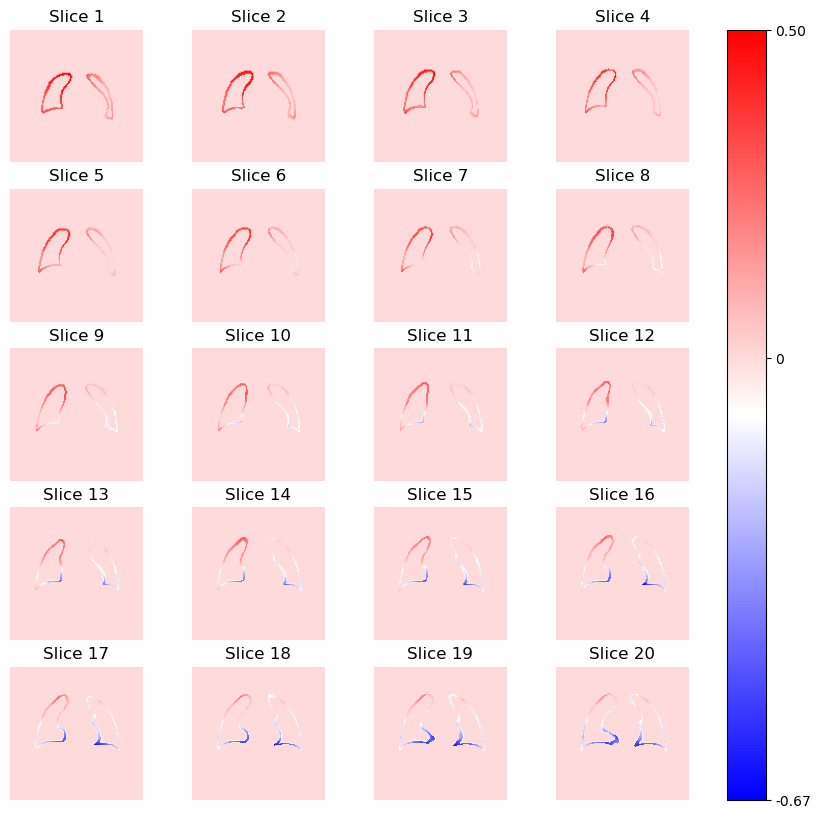

In [86]:
makeSlide(masked_phase[:, :, 50:70])

In [87]:
border_mask_dilated = extract_border_mask(dilated_mask)

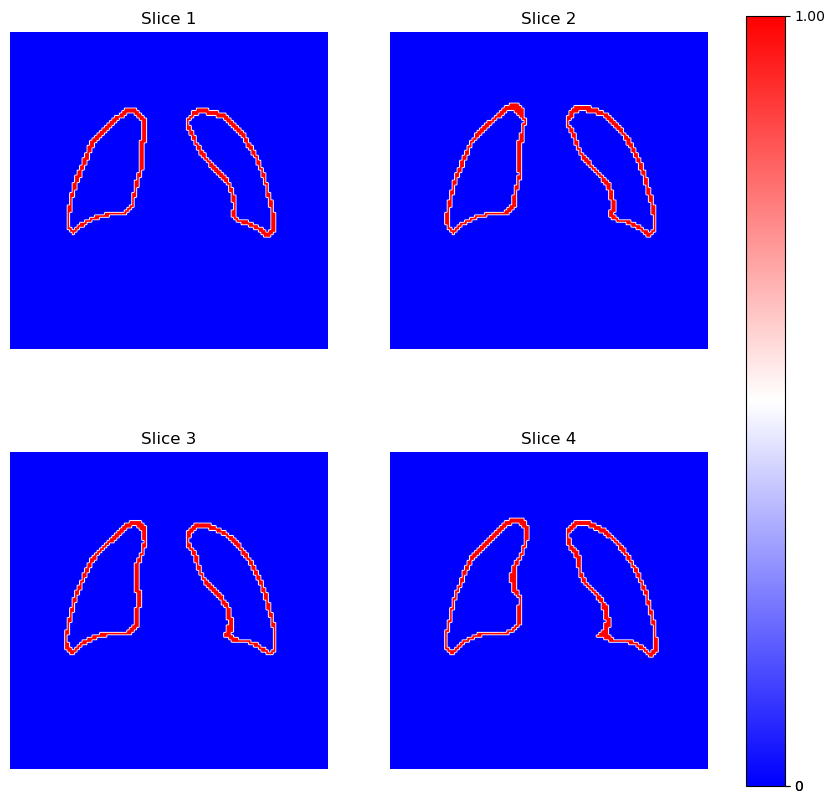

In [88]:
makeSlide(border_mask_dilated[:, :, 60:64])

In [92]:

# Assume mask_vent is the original binary mask and dilated_mask is the dilated mask

# Create a mask to select pixels between the original and dilated masks
between_masks_mask = (mask_vent == 0) & (dilated_mask == 1)

# Convert the selected pixels to NaN in the masked_phase array
masked_phase[between_masks_mask] = np.nan


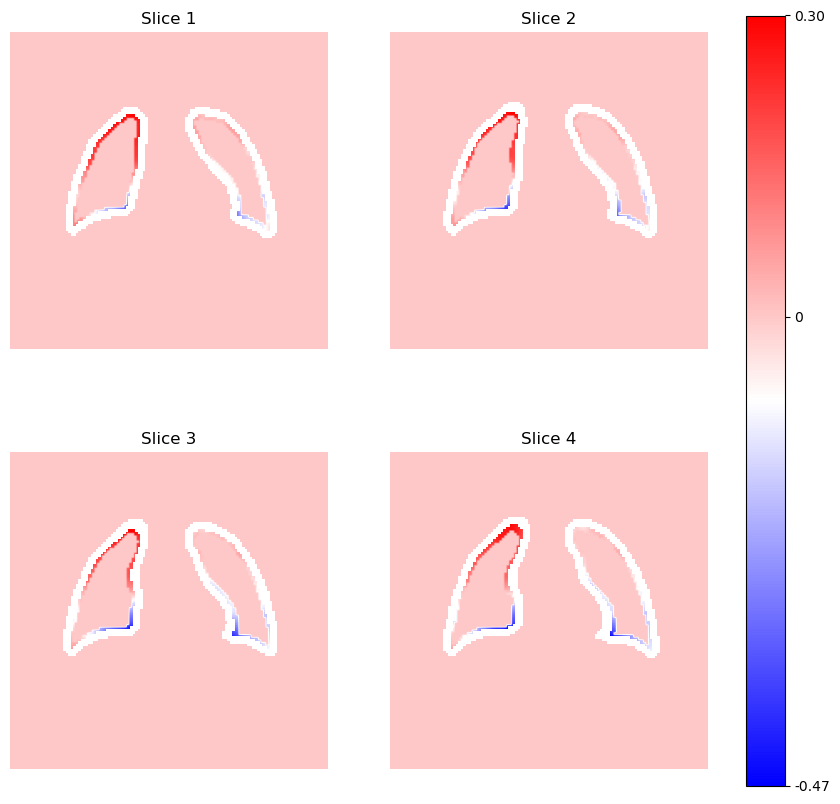

In [93]:
makeSlide(masked_phase[:, :, 60:64])

### 6. Manual Gradient 

In [159]:
# empty array to store the final result
smoothed_phase_map = np.zeros_like(phase_inside_mask)
gradient_array = np.zeros_like(phase_inside_mask)
dilated_mask = np.zeros_like(phase_inside_mask)

# iterate over each slice 
for i in range(phase_inside_mask.shape[0]):
    # slice of the mask
    current_mask_slice = mask_vent[i]

    # apply morphological dilation to the current slice of the mask
    kernel = np.ones((10, 10), np.uint8)
    dilated_mask_slice = cv2.dilate(current_mask_slice.astype(np.uint8), kernel, iterations=1)
    dilated_mask[i] = dilated_mask_slice[i]

    # create a gradient from the border of the original mask to the border of the dilated mask
    gradient = np.linspace(0, 1, num=128)  # linear gradient from 0 to 1
    gradient = gradient ** 2  # increase contrast by raising to a power
    gradient = gradient[:, np.newaxis]  # convert to a column vector
    gradient = np.repeat(gradient, 128, axis=1)  # repeat the gradient along rows
    gradient = np.where(dilated_mask_slice == 1, gradient, 1)  # apply gradient only outside the mask
    gradient_array[i] = gradient[i]

    # blend the phase_inside_mask with the gradient
    smoothed_phase_map[i] = phase_inside_mask[i] * gradient

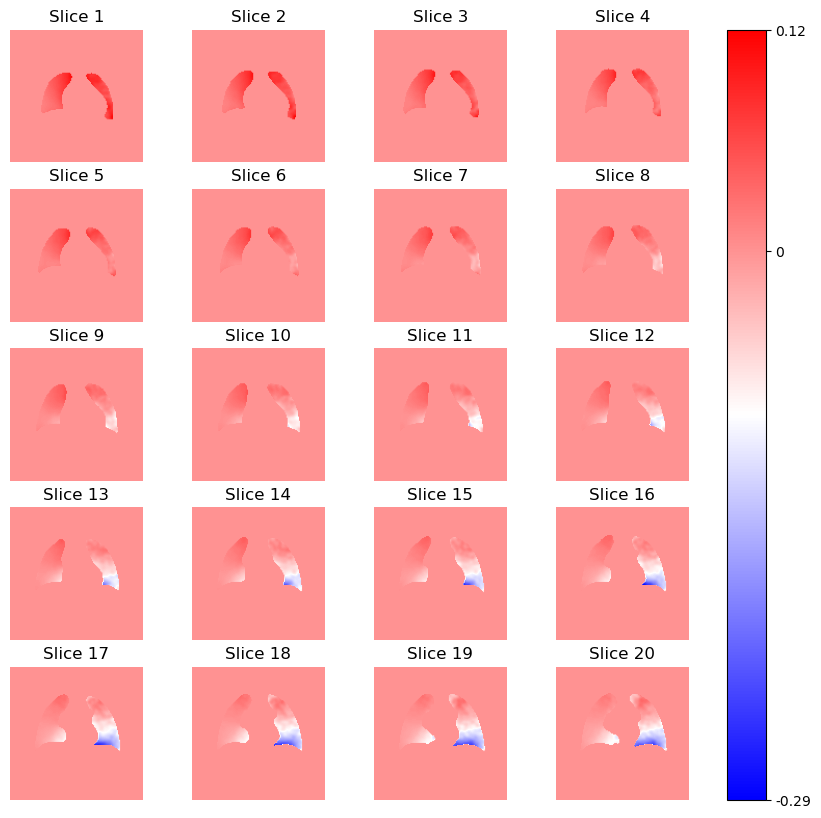

In [160]:
makeSlide(smoothed_phase_map[:, :, 50:70])

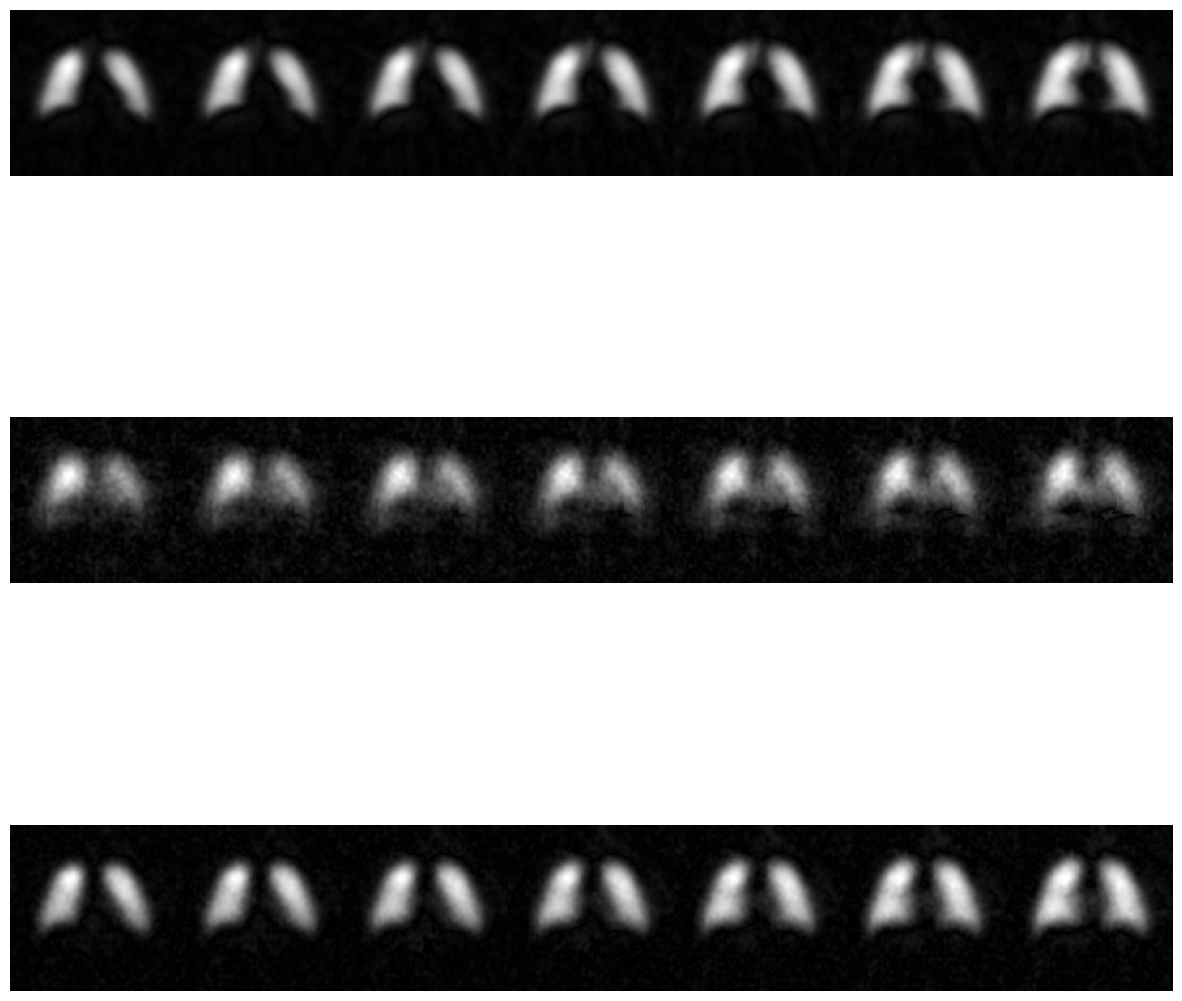

In [161]:
image_dixon = np.multiply(dissolved, np.exp(1j * (delta_angle)))
image_dixon = np.multiply(image_dixon, np.exp(1j * (-smoothed_phase_map)))
image_rbc = (
        np.imag(image_dixon)
        if np.mean(np.imag(image_dixon)) > 0
        else -1 * np.imag(image_dixon)  # type: ignore
    )
image_membrane = (
        np.real(image_dixon)
        if np.mean(np.real(image_dixon)) > 0
        else -1 * np.real(image_dixon)  # type: ignore
    )

        
plt.figure(figsize=(15,15))
display_slices(gas_highSNR, row=0);display_slices(image_rbc, row=1);display_slices(image_membrane, row=2)
plt.show()

THOUGHTS: introduces new artifacts to RBC. Not good. 

### 7. Dilation & Blurring of Entire Phase Inside Mask Map

In [31]:
import cv2
# empty array to store the result
result = np.zeros_like(phase_inside_mask)

# itterate over each slice
for i in range(phase_inside_mask.shape[0]):
    # extract the current slice
    phase_slice = phase_inside_mask[i]
    mask_slice = mask_vent[i]

    # apply operations to the slice
    mask_slice_uint8 = mask_slice.astype(np.uint8)
    # threshold the mask to create a binary mask
    _, binary_mask = cv2.threshold(mask_slice_uint8, 127, 255, cv2.THRESH_BINARY)
    # perform dilation to expand the mask
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)
    # blur the dilated mask
    blurred_dilated_mask = cv2.GaussianBlur(dilated_mask.astype(np.float32), (0, 0), sigmaX=5, sigmaY=5)
    # invert the blurred dilated mask
    inverted_blurred_dilated_mask = cv2.bitwise_not(blurred_dilated_mask.astype(np.uint8))
    # blur the phase slice
    blurred_phase_slice = cv2.GaussianBlur(phase_slice, (0, 0), sigmaX=5, sigmaY=5)
    # combine the blurred phase slice with the inverted dilated mask
    result_slice = cv2.bitwise_and(blurred_phase_slice, blurred_phase_slice, mask=inverted_blurred_dilated_mask)

    # store the processed slice 
    result[i] = result_slice

# 'result' contains the phase array with the desired blurring effect around the mask border

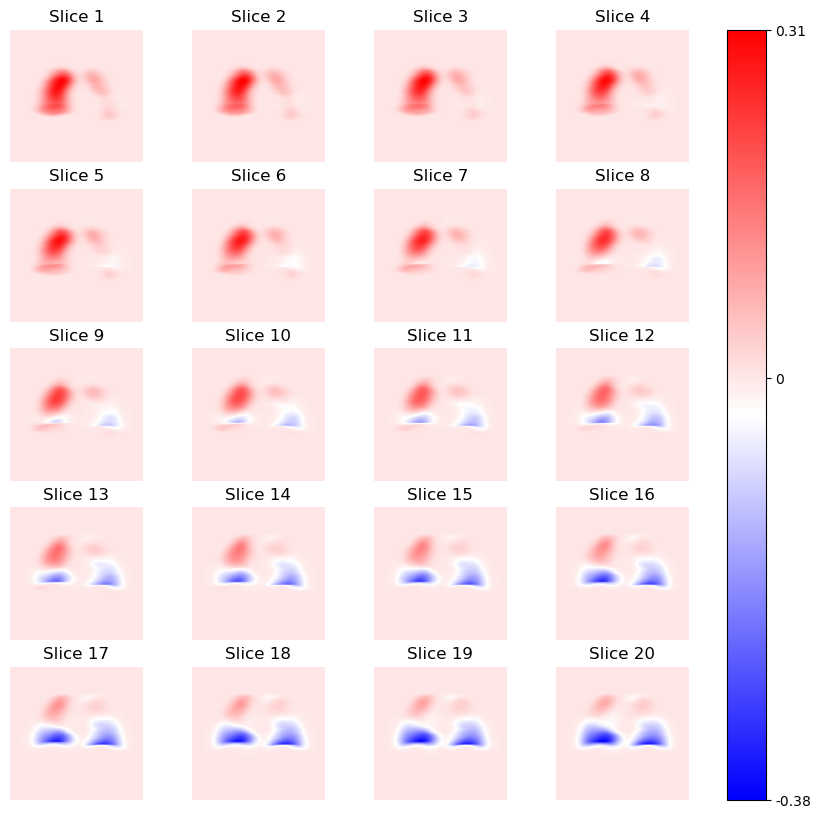

In [32]:
makeSlide(result[:, :, 50:70])

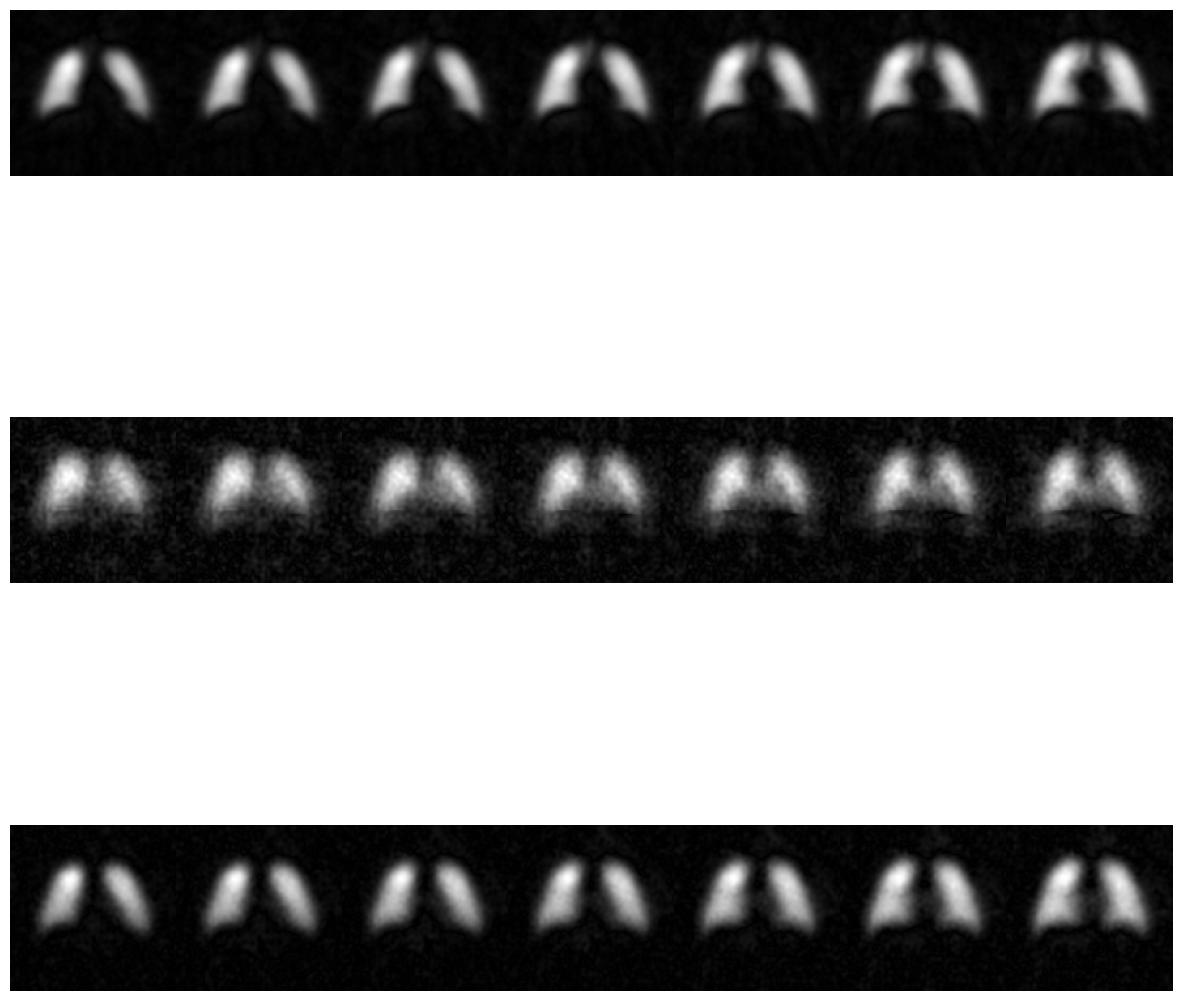

In [33]:
image_dixon = np.multiply(dissolved, np.exp(1j * (delta_angle)))
image_dixon = np.multiply(image_dixon, np.exp(1j * (-result)))
image_rbc = (
        np.imag(image_dixon)
        if np.mean(np.imag(image_dixon)) > 0
        else -1 * np.imag(image_dixon)  # type: ignore
    )
image_membrane = (
        np.real(image_dixon)
        if np.mean(np.real(image_dixon)) > 0
        else -1 * np.real(image_dixon)  # type: ignore
    )
        
plt.figure(figsize=(15,15))
display_slices(gas_highSNR, row=0);display_slices(image_rbc, row=1);display_slices(image_membrane, row=2)
plt.show()

THOUGHTS: also appears to add new undesirable artifacts to RBC image. Not good. 

### 8. Dilation & Blurring With Phase Inside Mask Overlaid 

In [34]:
import cv2

# Empty array to store the result
result = np.zeros_like(phase_inside_mask)

# Iterate over each slice
for i in range(phase_inside_mask.shape[0]):
    # Extract the current slice
    phase_slice = phase_inside_mask[i]
    mask_slice = mask_vent[i]

    # Apply operations to the slice
    mask_slice_uint8 = mask_slice.astype(np.uint8)

    # Threshold the mask to create a binary mask
    _, binary_mask = cv2.threshold(mask_slice_uint8, 127, 255, cv2.THRESH_BINARY)

    # Perform dilation to expand the mask
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    # Blur the dilated mask
    blurred_dilated_mask = cv2.GaussianBlur(dilated_mask.astype(np.float32), (0, 0), sigmaX=1, sigmaY=1)

    # Invert the blurred dilated mask
    inverted_blurred_dilated_mask = cv2.bitwise_not(blurred_dilated_mask.astype(np.uint8))

    # Blur the phase slice
    blurred_phase_slice = cv2.GaussianBlur(phase_slice, (0, 0), sigmaX=5, sigmaY=5)

    # Combine the blurred phase slice with the inverted dilated mask
    result_slice = cv2.bitwise_and(blurred_phase_slice, blurred_phase_slice, mask=inverted_blurred_dilated_mask)

    # Store the processed slice 
    result[i] = result_slice

In [35]:
# Determine minimum and maximum values in phase_inside_mask
min_value = np.min(phase_inside_mask)
max_value = np.max(phase_inside_mask)

# Normalize the result array to match the scale of phase_inside_mask
result_normalized = (result - result.min()) / (result.max() - result.min())  # Normalize result
result_on_scale = result_normalized * (max_value - min_value) + min_value  # Scale result to match phase_inside_mask

# Overlay the normalized result with the phase_inside_mask using appropriate blending techniques
final_result = np.where(mask_vent, phase_inside_mask, result)

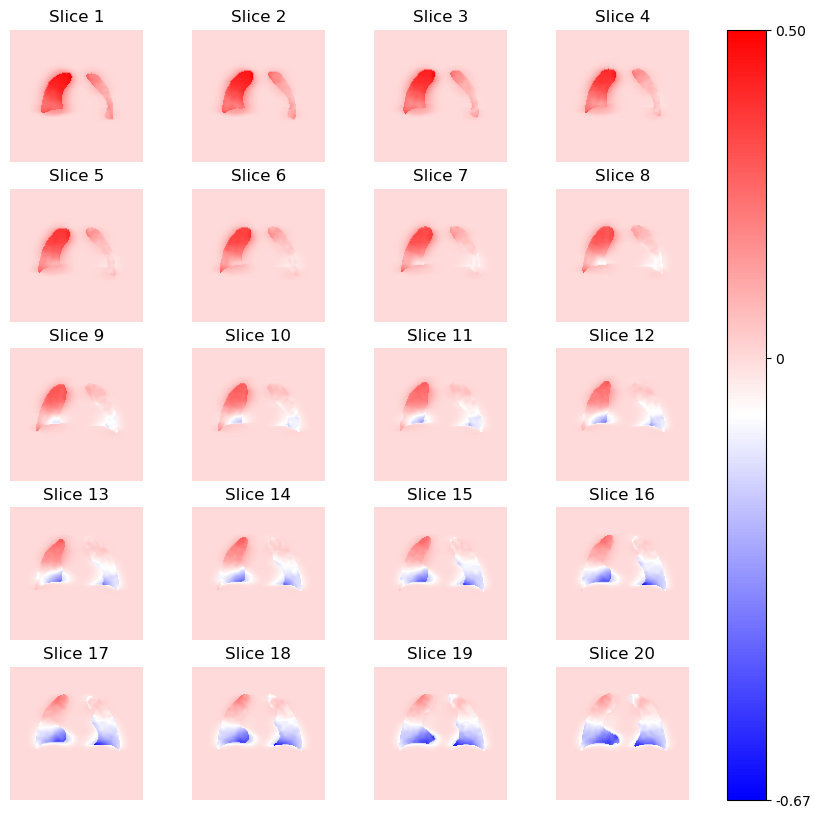

In [36]:
makeSlide(final_result[:, :, 50:70])

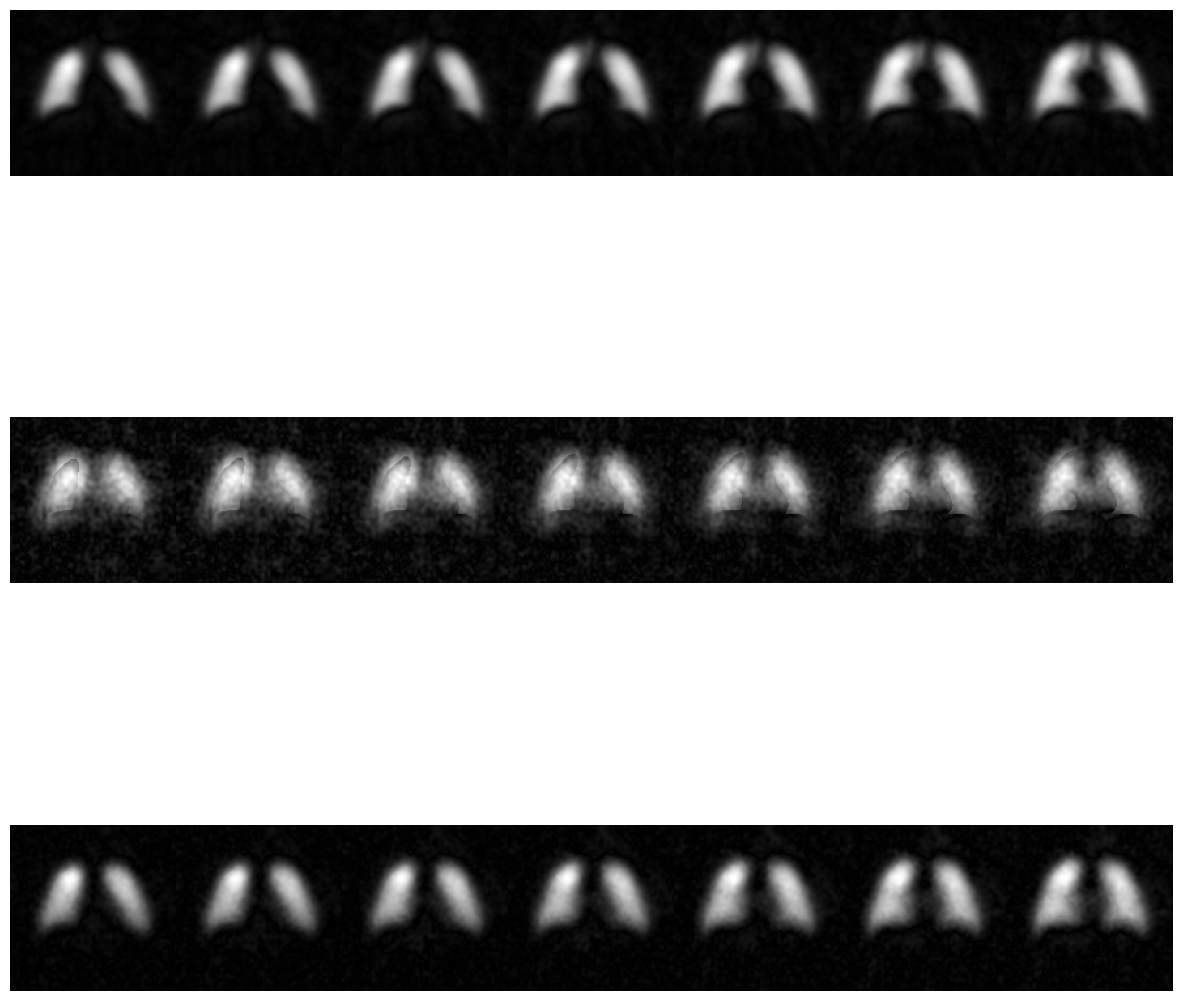

In [37]:
image_dixon = np.multiply(dissolved, np.exp(1j * (delta_angle)))
image_dixon = np.multiply(image_dixon, np.exp(1j * (-final_result)))
image_rbc = (
        np.imag(image_dixon)
        if np.mean(np.imag(image_dixon)) > 0
        else -1 * np.imag(image_dixon)  # type: ignore
    )
image_membrane = (
        np.real(image_dixon)
        if np.mean(np.real(image_dixon)) > 0
        else -1 * np.real(image_dixon)  # type: ignore
    )
        
plt.figure(figsize=(15,15))
display_slices(gas_highSNR, row=0);display_slices(image_rbc, row=1);display_slices(image_membrane, row=2)
plt.show()

THOUGHTS: issues with scaling once overlaying. The scale of the blurred phase image is much lower than the original phase inside of the mask so these borders do not become smooth, maybe even a little worse in some cases. The ring around the lung is not desired. Overall RBC images are not good at all. 

## Original Dixon Code and Images

In [38]:
image_dixon = np.multiply(dissolved, np.exp(1j * (delta_angle)))
image_dixon = np.multiply(image_dixon, np.exp(1j * (-diffphase)))

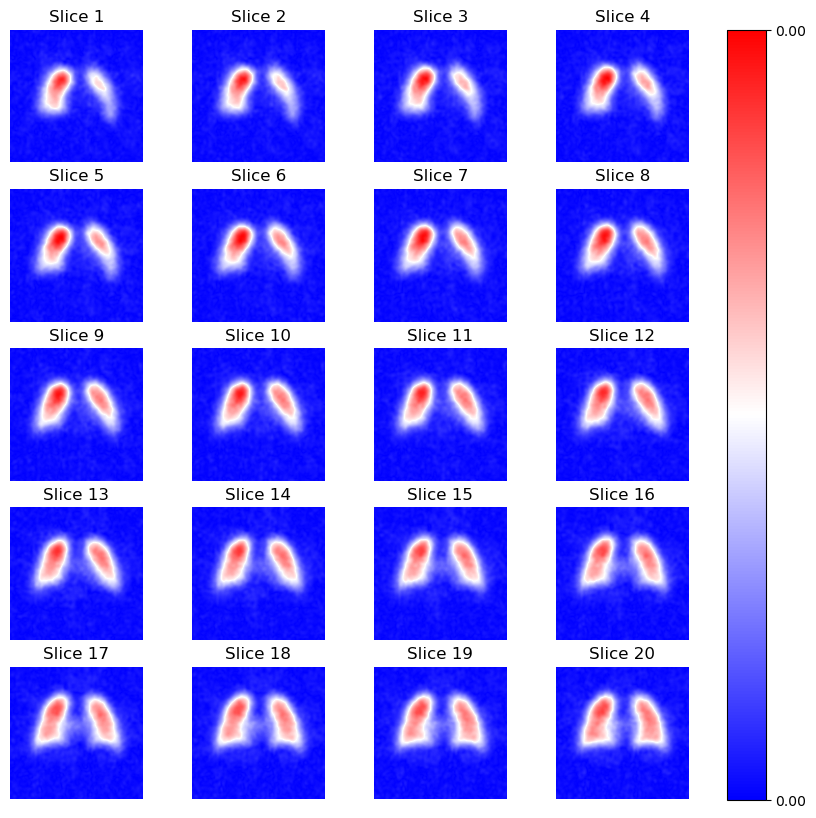

In [39]:
makeSlide(abs(image_dixon[:,:,50:70])) ## Abs value of image_dixon doesn't show any artifact around the heart
    # separate RBC and membrane components
image_rbc = (
        np.imag(image_dixon)
        if np.mean(np.imag(image_dixon)) > 0
        else -1 * np.imag(image_dixon)  # type: ignore
    )
image_membrane = (
        np.real(image_dixon)
        if np.mean(np.real(image_dixon)) > 0
        else -1 * np.real(image_dixon)  # type: ignore
    )

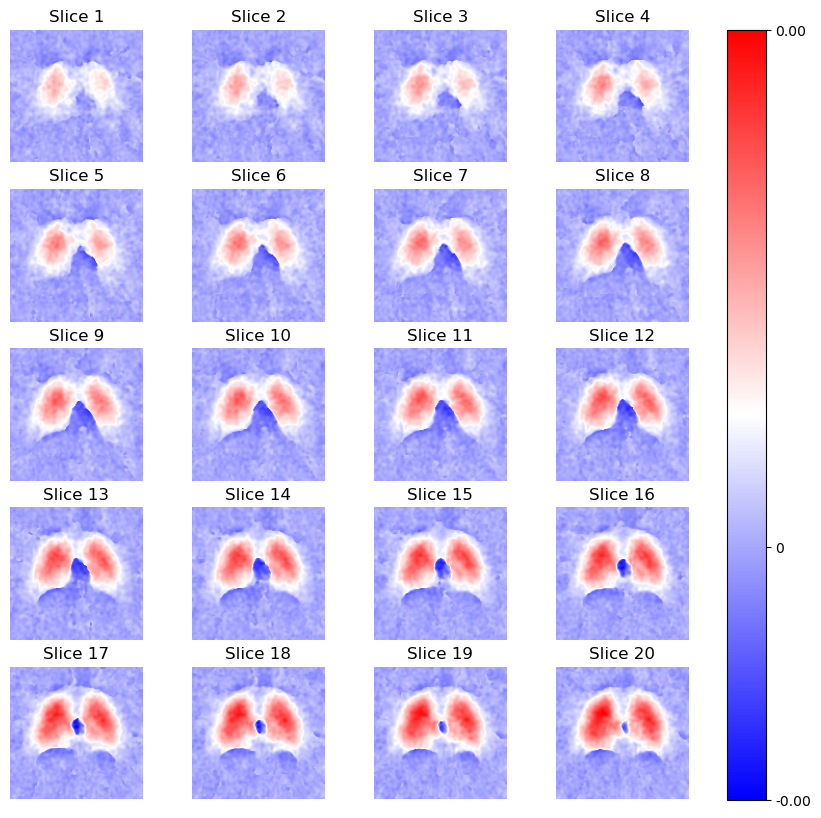

In [40]:
makeSlide((image_rbc[:,:,50:70]))
# Function to display the selected slices

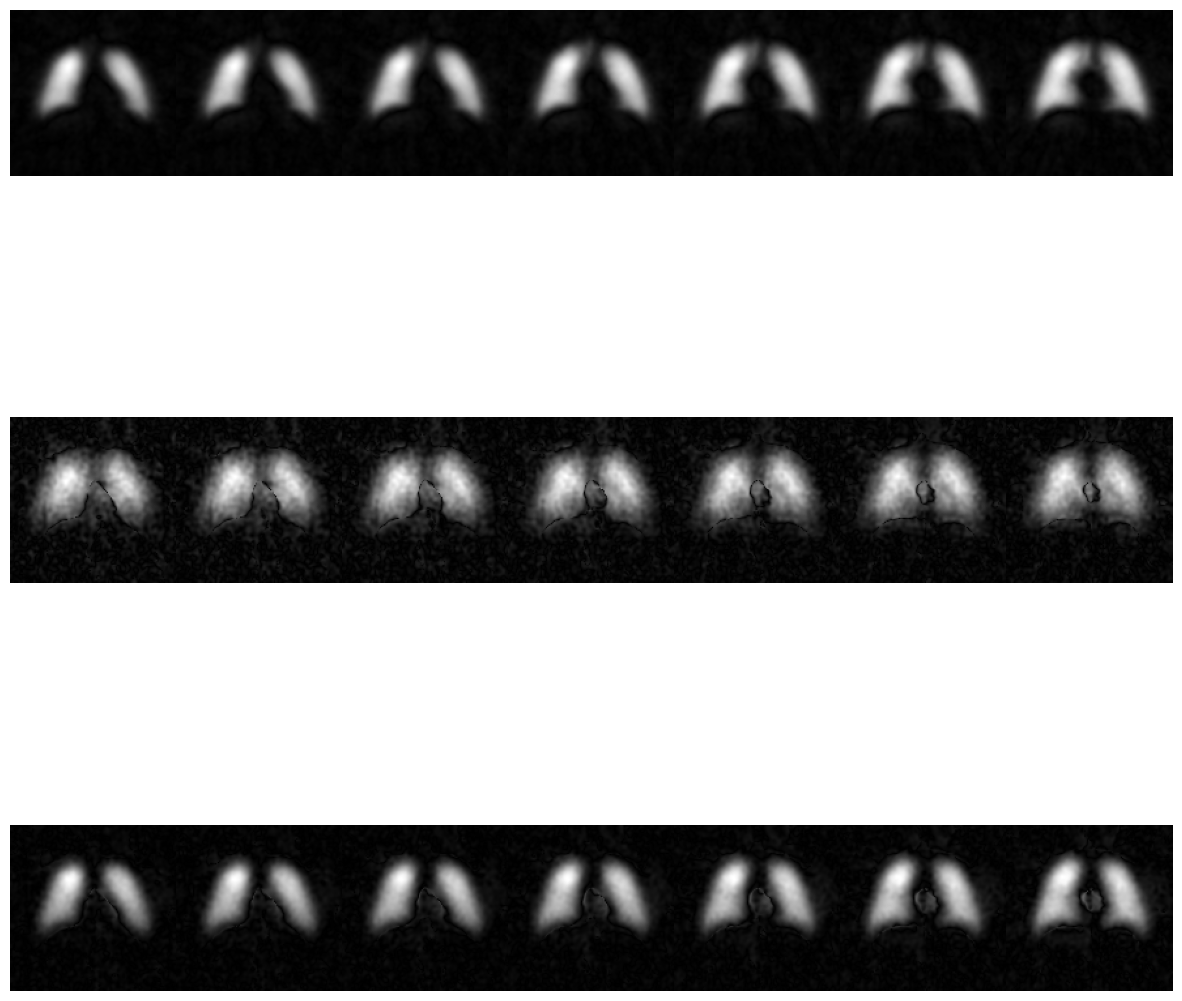

In [43]:
# Display the selected slices for each array
plt.figure(figsize=(15,15))
display_slices(gas_highSNR, row=0);display_slices(image_rbc, row=1);display_slices(image_membrane, row=2)
plt.show()